This notebook is a test to compare float grounding pressure with bathymetry products, on a specific region  
__author__ = 'kevin.balem@ifremer.fr'
Here's the 1st plan :
- Get float index
- Subset region of interest
- Get/Set floats url
- Xarray open if files exists, and preprocess at max
- Subset again region of interest
- Interp etopo at cycles positions
- Map both bathy and difference
- Stat it (deviationS, errors, ...)

In [3]:
%config Completer.use_jedi = False
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import scipy.interpolate as interpolate
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')

In [4]:
ix = pd.read_csv('/home/ref-argo/gdac/ar_index_global_prof.txt', 
                 sep=',', index_col=None, header=0, skiprows=8,
                 names=['file','date','latitude','longitude','ocean','profiler_type','institution','update'], 
                 dtype={'file': np.unicode_, 'latitude': np.float32, 'longitude': np.float32, 'ocean': np.str, 'profiler_type': np.str, 'institution': np.str}
                )
ix.tail()

,file,date,latitude,longitude,ocean,profiler_type,institution,update
2730047,nmdis/2901633/profiles/R2901633_067.nc,2.013050e+13,27.462000,139.106995,P,841,NM,20130507103443
2730048,nmdis/2901633/profiles/R2901633_068.nc,2.013051e+13,27.431999,138.839996,P,841,NM,20130511165723
2730049,nmdis/2901633/profiles/R2901633_069.nc,2.013052e+13,27.691999,138.677002,P,841,NM,20130521170139
2730050,nmdis/2901633/profiles/R2901633_070.nc,2.013053e+13,27.895000,138.464996,P,841,NM,20130531181516
2730051,nmdis/2901633/profiles/R2901633_071.nc,2.013061e+13,27.931000,138.089996,P,841,NM,20130617181801


In [240]:
ixs = ix[(ix['profiler_type']=='838')&(ix['date']>=20190000000000)]
tot_prof = len(ixs)
ixs = ixs.reset_index().drop(columns='index')

dacs = {'AO':'aoml','BO':'bodc','IF':'coriolis','HZ':'csio','CS':'csiro','IN':'incois','JA':'jma','KM':'kma','KO':'kordi','ME':'meds','NM':'nmdis'}
ixs['wmo']=[f.split('/')[1] for f in ixs['file']]
ixs['dac']=[dacs[f] for f in ixs['institution']]
ixs = ixs.groupby('wmo').max().reset_index()
ixs

/export/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  


,wmo,file,date,latitude,longitude,profiler_type,institution,update,dac
0,2902737,csio/2902737/profiles/R2902737_160.nc,2.022050e+13,-60.791000,157.078003,838,HZ,20220501120010,csio
1,2902738,csio/2902738/profiles/R2902738_142.nc,2.021113e+13,7.507000,158.296997,838,HZ,20211129080011,csio
2,2902739,csio/2902739/profiles/R2902739_085.nc,2.022113e+13,13.906000,133.589005,838,HZ,20221128080011,csio
3,2902740,csio/2902740/profiles/R2902740_085.nc,2.022113e+13,14.238000,143.746994,838,HZ,20221125080010,csio
4,2902741,csio/2902741/profiles/R2902741_155.nc,2.022022e+13,-47.509998,-126.551003,838,HZ,20220219080013,csio
...,...,...,...,...,...,...,...,...,...
83,6903869,coriolis/6903869/profiles/R6903869_003.nc,2.021070e+13,49.535000,-21.820999,838,IF,20210804080153,coriolis
84,6903870,coriolis/6903870/profiles/R6903870_054.nc,2.022113e+13,52.970001,-23.827999,838,IF,20221125123147,coriolis
85,6903871,coriolis/6903871/profiles/R6903871_054.nc,2.022120e+13,57.673000,-28.738001,838,IF,20221201134603,coriolis
86,6903872,coriolis/6903872/profiles/R6903872_054.nc,2.022120e+13,63.287998,-29.974001,838,IF,20221203083904,coriolis


In [220]:
# HARD MODE, GROUNDING DURING DESCENT TO PROFILE DEPTH
df1 = xr.Dataset({"LATITUDE":(["N_PROF"],[]),"LONGITUDE": (["N_PROF"],[]),"WMO": (["N_PROF"],[]),"Zg": (["N_PROF"],[]), "Zp": (["N_PROF"],[])},coords={})
for i in range(len(ixs)):    
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"   
    urld="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_prof.nc"    
    
    if (os.path.exists(urlt)):
        try:
            dt = xr.open_dataset(urlt)                    
            cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y','P','B','C'])).T[0]
            try:
                grounded = dt['CYCLE_NUMBER_INDEX'].values[cycles_grounded]
            except KeyError:
                try:
                    grounded = dt['CYCLE_NUMBER_ACTUAL'].values[cycles_grounded]
                except KeyError:
                    grounded = []
        except:
            print('issue on : '+urlt)
            grounded = []            
        if (len(grounded)>0):            
            try:
                dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()
                # GROUNDING DATE > PARKING DRIFT END ?
                # Here we make sure that grounding occurs in the descent to profile depth and not during parking drift. We do that comparing grounding time 
                # (meas code 901) and parking drift end (meas code 300)
                park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
                a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
                     for i in range(len(dg['CYCLE_NUMBER'].values))]
                a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
                dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
                dg = dg.where(dg['grd_on_prf']==True,drop=True)
                
                dd = xr.open_dataset(urld)
                # PROFILE DATA
                ds = dd.isel(N_PROF=dd['N_PROF'].values[np.isin(dd['CYCLE_NUMBER'].values,
                                                                dg['CYCLE_NUMBER'].values)])[['PRES','JULD','CYCLE_NUMBER',
                                                                                              'LATITUDE','LONGITUDE']].groupby('CYCLE_NUMBER').last()               
                # MAX PRES AND DEPTH CALCULATION for ds and dg
                ds = ds.max('N_LEVELS')
                ds['Z'] = -1*xr.DataArray(gsw.z_from_p(ds['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')
                dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')                
                
                dtmp = xr.Dataset({"LATITUDE":("N_PROF",ds['LATITUDE'].values),
                                   "LONGITUDE":("N_PROF",ds['LONGITUDE'].values),
                                   "WMO":("N_PROF",np.zeros_like(ds['LONGITUDE'].values)+int(ixs['wmo'][i])),
                                   "Zg": ("N_PROF",dg['Z'].values),
                                   "Zp": ("N_PROF",ds['Z'].values)},coords={})
                    
                df1=xr.concat([df1,dtmp],dim='N_PROF')
            except:
                print('issue on : '+urld) 
                pass
df1 = df1.sortby('LONGITUDE')
print(df1)

Exception ignored in: <function CachingFileManager.__del__ at 0x7fb5139830e0>
Traceback (most recent call last):
  File "/export/home/anaconda3/lib/python3.7/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    self.close(needs_lock=False)
  File "/export/home/anaconda3/lib/python3.7/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "netCDF4/_netCDF4.pyx", line 2525, in netCDF4._netCDF4.Dataset.close
  File "netCDF4/_netCDF4.pyx", line 2489, in netCDF4._netCDF4.Dataset._close
  File "netCDF4/_netCDF4.pyx", line 1928, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: No such file or directory
Exception ignored in: <function CachingFileManager.__del__ at 0x7fb5139830e0>
Traceback (most recent call last):
  File "/export/home/anaconda3/lib/python3.7/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    self.close(needs_lock=False)
  File "/export/home/anaconda3/lib/python3.7/site-packages/xarray/backends/fi

issue on : /home/ref-argo/gdac/dac/csio/2902737/2902737_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/csio/2902738/2902738_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/csio/2902739/2902739_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/csio/2902740/2902740_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/csio/2902741/2902741_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/coriolis/6903086/6903086_prof.nc
issue on : /home/ref-argo/gdac/dac/coriolis/6903571/6903571_prof.nc
<xarray.Dataset>
Dimensions:    (N_PROF: 2829)
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float64 59.71 59.76 59.19 59.37 ... -63.11 -63.26 -63.25
    LONGITUDE  (N_PROF) float64 -58.47 -58.38 -58.33 -58.3 ... 163.1 163.1 163.5
    WMO        (N_PROF) float64 6.903e+06 6.903e+06 ... 3.902e+06 3.902e+06
    Zg         (N_PROF) float64 2.716e+03 2.766e+03 ... 2.898e+03 2.813e+03
    Zp         (N_PROF) float64 2.715e+03 2.763e+03 ... 2.895e+03 2.809e+03


In [222]:
# HARD MODE, SKIP IF ANY ISSUE
# INIT DS OUT
df2 = xr.Dataset({"LATITUDE":(["N_PROF"],[]),"LONGITUDE": (["N_PROF"],[]),"WMO": (["N_PROF"],[]),"Zg": (["N_PROF"],[])},coords={})
for i in range(len(ixs)):    
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"   
    urld="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_prof.nc"    
    
    if (os.path.exists(urlt)):
        try:
            dt = xr.open_dataset(urlt)        
            # Check if there's any grounding with the GROUNDED variable
            cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y','P','B','C'])).T[0]
            try:
                grounded = dt['CYCLE_NUMBER_INDEX'].values[cycles_grounded]
            except KeyError:
                try:
                    grounded = dt['CYCLE_NUMBER_ACTUAL'].values[cycles_grounded]
                except KeyError:
                    grounded = []
        except:            
            print('issue on : '+urlt)
            grounded = []
        # IF there's any ...
        if (len(grounded)>0):            
            try:
                dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').first()                
                # Here we make sure that grounding occurs in the descent to parking. We do that comparing grounding time 
                # (meas code 901) and parking drift end (meas code 250)
                park_start = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==250.,drop=True)                
                a = [(dg['JULD'][i].values - park_start['JULD'].where(park_start['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)<=0
                     for i in range(len(dg['CYCLE_NUMBER'].values))]
                a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
                dg['grd_on_park'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
                dg = dg.where(dg['grd_on_park']==True,drop=True)                                 
                
                # PROFILE DATA
                dd = xr.open_dataset(urld)
                ds = dd.isel(N_PROF=dd['N_PROF'].values[np.isin(dd['CYCLE_NUMBER'].values,dg['CYCLE_NUMBER'].values-1)])[['PRES','JULD',
                                                                                                        'CYCLE_NUMBER',
                                                                                                        'LATITUDE',
                                                                                                        'LONGITUDE']].groupby('CYCLE_NUMBER').last()                   
                # DEPTH CALCULATION for dg only (no need for ds in that case)
                ds = ds.max('N_LEVELS')                
                dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')               
                
                # PREVIOUS CYCLE LAST GPS FIX (meas code 703)
                dp = dt[['CYCLE_NUMBER','JULD','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==703.,drop=True).groupby('CYCLE_NUMBER').last()
                dp = dp.where(dp['CYCLE_NUMBER']==ds['CYCLE_NUMBER'],drop=True)                                                                                                                                
                
                dtmp = xr.Dataset({"LATITUDE":("N_PROF",dp['LATITUDE'].values),
                                   "LONGITUDE":("N_PROF",dp['LONGITUDE'].values),
                                   "WMO":("N_PROF",np.zeros_like(ds['LONGITUDE'].values)+int(ixs['wmo'][i])),
                                   "Zg": ("N_PROF",dg['Z'].values)
                                   },coords={})
                    
                df2=xr.concat([df2,dtmp],dim='N_PROF')
            except:                
                pass

#
df2 = df2.sortby('LONGITUDE')
print(df2)

issue on : /home/ref-argo/gdac/dac/csio/2902737/2902737_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/csio/2902738/2902738_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/csio/2902739/2902739_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/csio/2902740/2902740_Rtraj.nc
issue on : /home/ref-argo/gdac/dac/csio/2902741/2902741_Rtraj.nc
<xarray.Dataset>
Dimensions:    (N_PROF: 313)
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float64 62.04 61.8 58.13 56.89 ... 36.15 35.84 36.26
    LONGITUDE  (N_PROF) float64 -57.65 -56.67 -56.55 -56.31 ... 29.01 29.1 30.93
    WMO        (N_PROF) float64 6.903e+06 6.903e+06 ... 6.904e+06 6.904e+06
    Zg         (N_PROF) float64 2.597e+03 2.655e+03 ... 3.03e+03 2.036e+03


In [225]:
# SPREAD BATHY : Array of random points around position to interpolate bathy

PTS=np.array([np.asarray(Geodesic().circle(lon=df1['LONGITUDE'].isel(N_PROF=i).values,
                                           lat=df1['LATITUDE'].isel(N_PROF=i).values,
                                           radius=100.,
                                           n_samples=25.)) for i in range(len(df1['N_PROF']))])

radius = 2000.0 #in meters
radrange  = np.linspace(200,radius,10)
for r in radrange:
    PT0=np.array([np.asarray(Geodesic().circle(lon=df1['LONGITUDE'].isel(N_PROF=i).values,
                                               lat=df1['LATITUDE'].isel(N_PROF=i).values,
                                               radius=r,
                                               n_samples=50.)) for i in range(len(df1['N_PROF']))])
    PTS = np.column_stack((PTS,PT0))

x=xr.DataArray(PTS[:,:,0],dims=['N_PROF','PTS'])
y=xr.DataArray(PTS[:,:,1],dims=['N_PROF','PTS'])
spread_bathy1 = xr.Dataset()
spread_bathy1['etopo'] = -1*etopo.interp(x=x,y=y,method='linear')['z']
spread_bathy1['gebco'] = -1*gebco.interp(lon=x,lat=y,method='linear')['elevation']
print(spread_bathy1)

<xarray.Dataset>
Dimensions:  (N_PROF: 2829, PTS: 525)
Coordinates:
    x        (N_PROF, PTS) float64 -58.47 -58.47 -58.47 ... 163.5 163.5 163.5
    y        (N_PROF, PTS) float64 59.71 59.71 59.71 ... -63.24 -63.24 -63.23
    lon      (N_PROF, PTS) float64 -58.47 -58.47 -58.47 ... 163.5 163.5 163.5
    lat      (N_PROF, PTS) float64 59.71 59.71 59.71 ... -63.24 -63.24 -63.23
Dimensions without coordinates: N_PROF, PTS
Data variables:
    etopo    (N_PROF, PTS) float64 2.727e+03 2.727e+03 ... 2.862e+03 2.852e+03
    gebco    (N_PROF, PTS) float64 2.716e+03 2.716e+03 ... 2.737e+03 2.733e+03


In [226]:
# SPREAD BATHY : Array of random points around position to interpolate bathy
PTS=np.array([np.asarray(Geodesic().circle(lon=df2['LONGITUDE'].isel(N_PROF=i).values,
                                           lat=df2['LATITUDE'].isel(N_PROF=i).values,
                                           radius=100.,
                                           n_samples=25.)) for i in range(len(df2['N_PROF']))])

radius = 2000.0 #in meters
radrange  = np.linspace(200,radius,10)
for r in radrange:
    PT0=np.array([np.asarray(Geodesic().circle(lon=df2['LONGITUDE'].isel(N_PROF=i).values,
                                               lat=df2['LATITUDE'].isel(N_PROF=i).values,
                                               radius=r,
                                               n_samples=50.)) for i in range(len(df2['N_PROF']))])
    PTS = np.column_stack((PTS,PT0))

x=xr.DataArray(PTS[:,:,0],dims=['N_PROF','PTS'])
y=xr.DataArray(PTS[:,:,1],dims=['N_PROF','PTS'])
spread_bathy2 = xr.Dataset()
spread_bathy2['etopo'] = -1*etopo.interp(x=x,y=y,method='linear')['z']
spread_bathy2['gebco'] = -1*gebco.interp(lon=x,lat=y,method='linear')['elevation']
print(spread_bathy2)

<xarray.Dataset>
Dimensions:  (N_PROF: 313, PTS: 525)
Coordinates:
    x        (N_PROF, PTS) float64 -57.65 -57.65 -57.65 ... 30.94 30.94 30.94
    y        (N_PROF, PTS) float64 62.04 62.04 62.04 62.04 ... 36.28 36.28 36.28
    lon      (N_PROF, PTS) float64 -57.65 -57.65 -57.65 ... 30.94 30.94 30.94
    lat      (N_PROF, PTS) float64 62.04 62.04 62.04 62.04 ... 36.28 36.28 36.28
Dimensions without coordinates: N_PROF, PTS
Data variables:
    etopo    (N_PROF, PTS) float64 2.532e+03 2.532e+03 ... 2.424e+03 2.426e+03
    gebco    (N_PROF, PTS) float64 2.505e+03 2.504e+03 ... 2.343e+03 2.345e+03


### What's the spread ?
That's the interpolation of gebco or etopo depth inside a circle around the profile lat/lon.  
I find it easier than searching for min/max inside that same circle

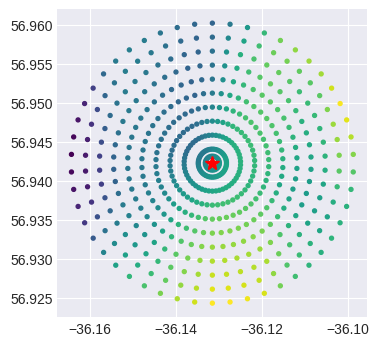

In [227]:
N=1000
plt.figure(figsize=(4,4))
plt.plot(df['LONGITUDE'].isel(N_PROF=N),df['LATITUDE'].isel(N_PROF=N),'*r',markersize=10.)
plt.scatter(spread_bathy['lon'].isel(N_PROF=N),spread_bathy['lat'].isel(N_PROF=N),c=spread_bathy['gebco'].isel(N_PROF=N),s=8.,cmap=plt.get_cmap('viridis'))

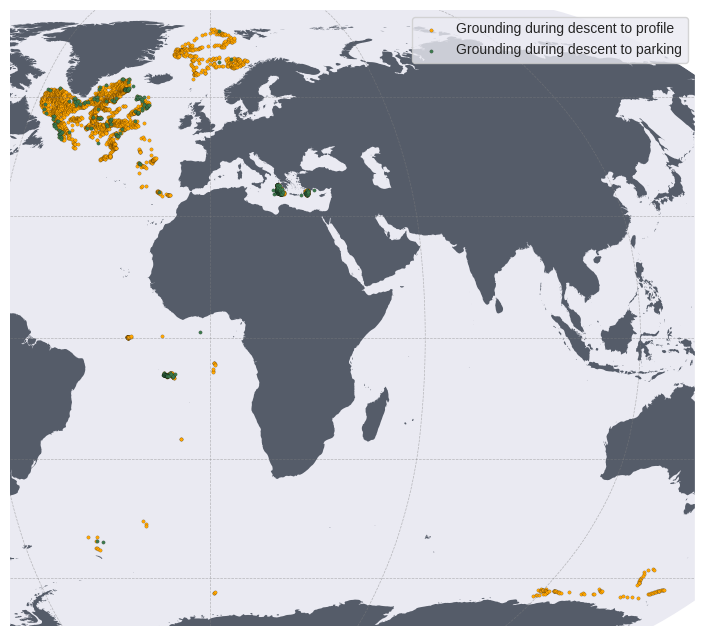

In [228]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.add_feature(land_feature, edgecolor=None)

ax.scatter(df1['LONGITUDE'],df1['LATITUDE'],s=6,c='orange',transform=ccrs.PlateCarree(),edgecolor='k',linewidth=0.1,label='Grounding during descent to profile')
ax.scatter(df2['LONGITUDE'],df2['LATITUDE'],s=6,c='#3c784c',transform=ccrs.PlateCarree(),edgecolor='k',linewidth=0.1,label='Grounding during descent to parking')
#ax.set_global()
ax.legend(frameon=True)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
gl.left_labels = False

Text(0, 0.5, 'Number of profiles')

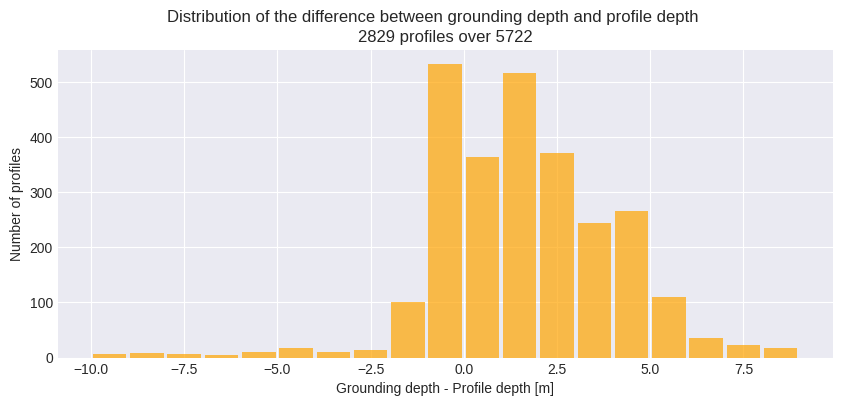

In [242]:
data0 = (df1['Zg'].values - df1['Zp'])
f,ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(data0, bins=np.arange(-10,10,1.0), density=False, alpha=0.7, color='orange',rwidth=0.9)
plt.suptitle('Distribution of the difference between grounding depth and profile depth')
ax.set_title(str(len(df1.N_PROF))+' profiles over '+str(tot_prof))
ax.set_xlabel(r'Grounding depth - Profile depth [m]')
ax.set_ylabel(r'Number of profiles')

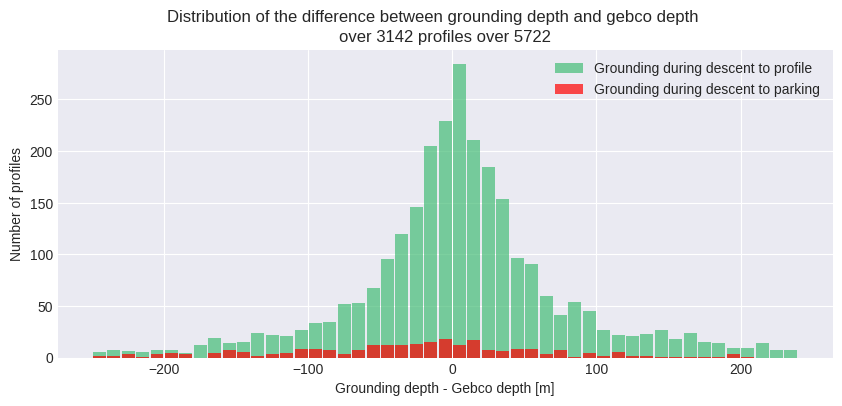

In [243]:
data0 = (df1['Zg'].values - spread_bathy1['gebco'].mean('PTS')).values
data1 = (df2['Zg'].values - spread_bathy2['gebco'].mean('PTS')).values

f,ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(data0, bins=np.arange(-250,250,10.0), density=False, alpha=0.7, color='#44bd76',rwidth=0.9,label='Grounding during descent to profile')
ax.hist(data1, bins=np.arange(-250,250,10.0), density=False, alpha=0.7, color='red',rwidth=0.9,label='Grounding during descent to parking')

plt.suptitle('Distribution of the difference between grounding depth and gebco depth')
ax.set_title('over '+str(len(df1.N_PROF)+len(df2.N_PROF))+' profiles over '+str(tot_prof))
ax.set_xlabel(r'Grounding depth - Gebco depth [m]')
ax.set_ylabel(r'Number of profiles')
ax.legend()


In [248]:
3142/5722

0.5491087032506117

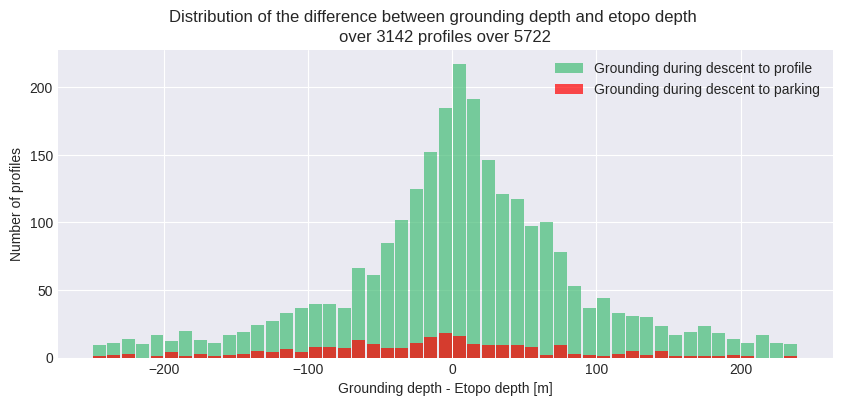

In [244]:
data0 = (df1['Zg'].values - spread_bathy1['etopo'].mean('PTS')).values
data1 = (df2['Zg'].values - spread_bathy2['etopo'].mean('PTS')).values

f,ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(data0, bins=np.arange(-250,250,10.0), density=False, alpha=0.7, color='#44bd76',rwidth=0.9,label='Grounding during descent to profile')
ax.hist(data1, bins=np.arange(-250,250,10.0), density=False, alpha=0.7, color='red',rwidth=0.9,label='Grounding during descent to parking')

plt.suptitle('Distribution of the difference between grounding depth and etopo depth')
ax.set_title('over '+str(len(df1.N_PROF)+len(df2.N_PROF))+' profiles over '+str(tot_prof))
ax.set_xlabel(r'Grounding depth - Etopo depth [m]')
ax.set_ylabel(r'Number of profiles')
ax.legend()


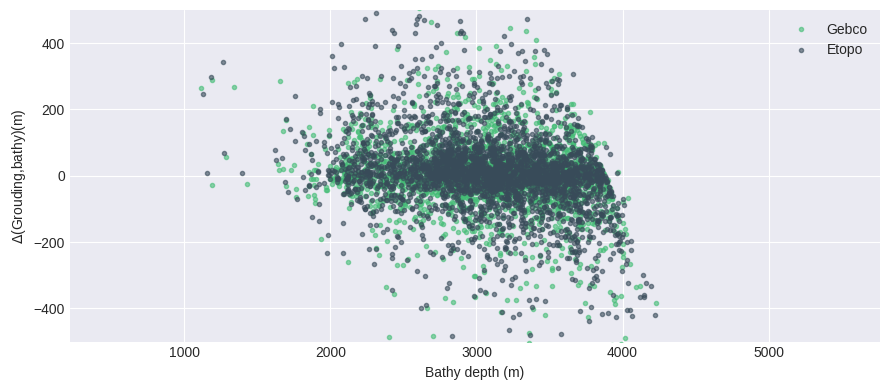

In [245]:
fig, ax = plt.subplots(1,1,figsize=(9,4),sharex=True)
ax.plot(spread_bathy['gebco'].mean('PTS'),df['Zg'].values - spread_bathy['gebco'].mean('PTS'),'o',color='#44bd76',markersize=3,alpha=0.6,label='Gebco')
ax.plot(spread_bathy['etopo'].mean('PTS'),df['Zg'].values - spread_bathy['etopo'].mean('PTS'),'o',color='#384b59',markersize=3,alpha=0.6,label='Etopo')

ax.set_ylim(-500,500)
ax.set_ylabel(r'$\Delta$(Grouding,bathy)(m)')
ax.set_xlabel('Bathy depth (m)')                 
ax.legend() 
    
plt.tight_layout()